### Imports

In [1]:
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import sympy as sym

In [2]:
# Set font size of plot elements\n",
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

### Some notes

The YIG operates like a hot bath, so the number of photons should be similar to the number of photons from the thermal bath $n_T$.

To solve for the number of photons in the cavity mode, we can use a delightful formula (see Kurt's notes for the citation).  If the integral has the form $I_n = \int_{-\infty}^{\infty}\frac{y_n(\nu)}{z_n(\nu)z_n(-\nu)}d\nu$, where $z_n{-\nu} = z_n(\nu)^*$, $y_n(\nu) = b_0\nu^{2n-2} + b_1\nu^{2n-4} + ... + b_{n-1}$, and $z_n(\nu) = a_0\nu^n + a_1\nu^{n-1} + ... + a_n$, then

$I_n = \frac{\pi}{a_0}\left|\frac{M_n}{L_n} \right|$, where $M_n = 
    \begin{vmatrix}
       b_0 & b_1 & b_2 & ... & b_{n-1} \\
       a_0 & a_2 & a_4 & ... & a_0 \\
       0 & a_1 & a_3 & ... & 0 \\
       \vdots & \vdots & \vdots & ... & \vdots \\
       0 & 0 & 0 & ... & a_n
    \end{vmatrix}$  and $L_n =
    \begin{vmatrix}
        a_1 & a_3 & a_5 & ... & 0 \\
       a_0 & a_2 & a_4 & ... & a_0 \\
       0 & a_1 & a_3 & ... & 0 \\
       \vdots & \vdots & \vdots & ... & \vdots \\
       0 & 0 & 0 & ... & a_n
    \end{vmatrix}$

So the idea is that we calculate what $S_A(\omega)$ is analytically, then input the terms into the matrices M and L and solve numerically for the average number of photons in the cavity mode.

When using the functions to get the a and b terms, note that they will not give you the expected results if you set the YIG terms to 0.  This is because they still create the 3x3 matrix and calculate the determinants with all of those zeros.  I haven't yet figured out how to take care of that with 1 function.

### Functions

In [3]:
def temp_from_photons(ω, num_photons):
    """
    function for calculating the temperature given the number of photons
    :param ω:           the frequency of the photons
    :param num_photons: the number of photons
    :returns:           the temperature
    """
    hbar_ov_k = 7.639e-12 
    return hbar_ov_k * ω / np.log(1 / num_photons + 1)

In [4]:
def photons_from_temp(ω, temp):
    """
    function for calculating the number of photons from a thermal bath
    :param ω:           the frequency of the photons
    :param temp:        the temperature of the bath
    :returns:           the number of photons
    """
    hbar_ov_k = 7.639e-12
    return (np.exp(hbar_ov_k * ω / temp) - 1) ** -1

In [5]:
def get_a_list(κ, γ, r, χ, g, gy):
    """
    function for calculating the a terms for the integral formula above
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the damping rate of the NV ensemble
    :param χ:  the damping rate of the YIG
    :param g:  the cooperativity of the cavity and the NV ensemble
    :param gy: the cooperativivity of the cavity and the YIG
    :returns:  list of the a coefficients
    """
    a0 = 1j
    a1 = 0.5 * (κ + γ + r + χ)
    a2 = 0.25j * ((κ + γ)*r + (κ + γ)*χ + r*χ + 4*g**2 + 4*gy**2)
    a3 = -0.5 * ((κ + γ)*r*χ / 4 + χ*g**2 + r*gy**2)

    return np.array([a0, a1, a2, a3])

In [6]:
def get_b_list(κ, γ, r, χ, g, gy, nc, ny, nT):
    """
    function for calculating the a terms for the integral formula above
    :param κ:  the output coupling rate of the cavity
    :param γ:  the internal loss rate of the cavity
    :param r:  the damping rate of the NV ensemble
    :param χ:  the damping rate of the YIG
    :param g:  the cooperativity of the cavity and the NV ensemble
    :param gy: the cooperativivity of the cavity and the YIG
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param ny: the number of photons in the YIG mode
    :param nT: the number of photons in the thermal bath
    :returns:  list of the b coefficients
    """
    b0 = (κ + γ)*nT
    b1 = 0.25 * (r**2 + χ**2) * (κ + γ)*nT + r*nc*g**2 + χ*ny*gy**2
    b2 = 0.25 * (r**2*χ**2 / 4 * (κ + γ) * nT + g**2 * χ**2 * r * nc + gy**2 * r**2 * χ * ny)

    return np.array([b0, b1, b2])

In [7]:
def m_det(b_list, a_list):
    """
    function for calculating the determinant of the M matrix in the integral formula above
    :param b_list: the list of the b coefficients
    :param a_list: the list of the a coefficients
    :returns:      the determinant of M
    """
    # First construct the matrix
    M = np.zeros((b_list.size, b_list.size), dtype=complex)

    # Now fill in with the appropriate values
    M[0, :] = b_list.copy()
    M[1, 0] = a_list[0]
    M[1, 1] = a_list[2]
    M[2, 1] = a_list[1]
    M[2, 2] = a_list[3]

    # Return the determinant
    return linalg.det(M)

In [8]:
def l_det(a_list):
    """
    function for calculating the determinant of the L matrix in the integral formula above
    :param a_list: the list of the a coefficients
    :returns:      the determinant of L
    """
    # First construct the matrix
    L = np.zeros((a_list.size-1, a_list.size-1), dtype=complex)

    # Now fill in with the appropriate values
    L[0, 0] = a_list[1]
    L[0, 1] = a_list[3]
    L[1, 0] = a_list[0]
    L[1, 1] = a_list[2]
    L[2, 1] = a_list[1]
    L[2, 2] = a_list[3]

    # Return the determinant
    return linalg.det(L)

In [9]:
def nv_mean_photons(κ, γ, g, r, nT, nc):
    """
    function for calculating the steady state photon number in the cavity per equation 98 in Kurt's supplemental info document
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :returns:  the average number of photons in the cavity mode
    """
    num = (κ + γ) * nT + r * g ** 2 / ((r / 2)**2 + (r / 2)*((κ + γ) / 2) + g ** 2) * nc
    den = (κ + γ) + r * g ** 2 / ((r / 2)**2 + (r / 2)*((κ + γ) / 2) + g ** 2)
    return num / den

In [10]:
def full_output_spec(ω, g, r, gy, χ, κ, γ, nT, nc, ny, Δ, Ω):
    """
    function for calculating the full output spectrum of the cavity including the YIG and NV ensemble
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param gy: the cooperativity of the YIG and the cavity
    :param χ:  the damping rate of the YIG
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param ny: the number of photons in the YIG
    :param Δ:  the cavity-spin detuning
    :param Ω:  the cavity-YIG detuning
    :returns:  the output spectrum
    """
    # Define M collect coupling rates together
    M = κ + γ

    # Numerator will be a + b + c, denominator will be d + e + f
    a = (r ** 2 / 4 + ω ** 2) * (χ ** 2 / 4 + ω ** 2) * κ * γ * nT
    b = g ** 2 * (χ ** 2 / 4 + ω ** 2) * nc
    c = gy ** 2 * (r ** 2 / 4 + ω ** 2) * ny
    a2 = ((κ - γ) / 2 + 1j * (ω - Δ)) * (r / 2 - 1j * ω) * (χ / 2 - 1j * (ω - Ω))
    b2 = g ** 2 * (χ / 2 - 1j * (ω - Ω))
    c2 = gy ** 2 * (r / 2 - 1j * ω)
    num = a + b + c + nT * np.abs(a2 - b2 - c2) ** 2

    d = ((κ + γ) / 2 - 1j * (ω - Δ)) * (r / 2 - 1j*ω) * (χ / 2 - 1j * (ω - Ω))
    e = g ** 2 * (χ / 2 - 1j*ω)
    f = gy ** 2 * (r / 2 - 1j*ω)
    den = np.abs(d + e + f) ** 2
    #print("a: ", a)
    #print("b: ", b)
    #print("c: ", c)
    #print("a2: ", a2)
    #print("b2: ", b2)
    #print("c2: ", c2)
    #print("a2 - b2 - c2 sq: ", nT * np.abs(a2 - b2 - c2) ** 2)
    #print("num: ", num)
    #print("d: ", d)
    #print("e: ", e)
    #print("f: ", f)
    #print("den: ", den)

    return num / den

In [11]:
def nv_output_spec(ω, g, r, κ, γ, nT, nc, Δ):
    """
    function for calculating the full output spectrum of the cavity with just the NV ensemble.  Note: this is mostly for testing purposes
    as the full output spectrum function should yield the same thing when the YIG terms are 0
    :param ω:  the frequency
    :param g:  the cooperativity of the NV ensemble and the cavity
    :param r:  the damping rate of the NV ensemble
    :param κ:  the output coupling rate
    :param γ:  the internal loss rate
    :param nT: the number of photons in the thermal bath
    :param nc: the number of photons in the cold bath (i.e. the NV ensemble)
    :param Δ:  the cavity-spin detuning
    :returns:  the output spectrum
    """
    num = κ * r * g ** 2 * (nc - nT)
    d = (r ** 2 / 4 + ω ** 2) * ((κ + γ) ** 2 /4 + (ω - Δ) ** 2)
    e = g ** 2 * (r * (κ + γ) / 2 - 2 * ω * (ω - Δ))
    f = g ** 4
    den = d + e + f
    #print("num: ", num)
    #print("d: ", d)
    #print("e: ", e)
    #print("f: ", f)
    #print("den: ", den)

    return nT + num / den

In [12]:
def test(ω, g, r, κ, γ, nT, nc, Δ):
    a = κ * γ * (r ** 2 / 4 + ω ** 2) * nT
    b = κ * r * g ** 2 * nc
    c = np.abs((r / 2 - 1j * ω) * ((κ - γ) / 2 + 1j * (ω - Δ)) - g ** 2) ** 2 * nT
    num = a + b + c

    den = np.abs((r / 2 - 1j * ω) * ((κ + γ) / 2 - 1j * (ω - Δ)) + g ** 2) ** 2
    #print("a: ", a)
    #print("b: ", b)
    #print("c: ", c)
    #print("num: ", num)
    #print("den: ", den)
    return num / den

### Test
The results including the YIG should reduce to the results of the NV-cavity setup when the YIG terms are set to 0.  This is a useful check that our code is functioning as expected.  We'll first check the average number of photons in the cavity mode, then we'll check the output spectrum.

In [13]:
# First define the parameters we'll need
ωc = 2 * np.pi * 2.87e9  # Hz
κ = 1
T = 5
Q = 2.5e4
γ = ωc / Q
g = 1e7 # Hz
r = g
P = 1
nc = 0.5 * (1 - P) / P
nT = photons_from_temp(ωc, T)

In [14]:
expected_nbar = nv_mean_photons(κ, γ, g, r, nT, nc)

In [15]:
# Now, we can't actually just use the functions above to generate the results without the YIG.  This is because the size of the matrices
# get messed up.  So we have to do it manually
# With the YIG off, we have n=2 for M_n and L_n.  That means we need a0, a1, a2 and b0, b1.
a0 = 1
a1 = 1j*(r + κ + γ) / 2
a2 = -(κ + γ) * r / 4 - g ** 2
b0 = (κ + γ) * nT
b1 = (κ + γ) * nT / 4 * r ** 2 + r * nc + g ** 2

M2 = np.array([[b0, b1], [a0, a2]])
M2_det = linalg.det(M2)
L2 = np.array([[a1, 0], [a0, a2]])
L2_det = linalg.det(L2)
    
no_yig_nbar = 1 / (2 *np.abs(a0)) * np.abs(M2_det / L2_det)

In [16]:
print("Expected $\\bar{n}$: ", expected_nbar)
print("Calculated $\\bar{n}$: ", no_yig_nbar)

Expected $\bar{n}$:  2.9999823055234396
Calculated $\bar{n}$:  2.999982397143455


In [17]:
g = np.logspace(6, 8, 1000)
r = g.copy()
expected_nbar = nv_mean_photons(κ, γ, g, r, nT, nc)

In [18]:
no_yig_nbar = np.zeros(g.shape[0], dtype=complex)
for i in range(g.shape[0]):
    temp_a0 = 1
    temp_a1 = 1j*(r[i] + κ + γ) / 2
    temp_a2 = -(κ + γ) * r[i] / 4 - g[i] ** 2
    temp_b0 = (κ + γ) * nT
    temp_b1 = (κ + γ) * nT / 4 * r[i] ** 2 + r[i] * nc + g[i] ** 2

    temp_M2 = np.array([[temp_b0, temp_b1], [temp_a0, temp_a2]])
    temp_M2_det = linalg.det(temp_M2)
    temp_L2 = np.array([[temp_a1, 0], [temp_a0, temp_a2]])
    temp_L2_det = linalg.det(temp_L2)

    no_yig_nbar[i] = 1 / (2 *np.abs(temp_a0)) * np.abs(temp_M2_det / temp_L2_det)

/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


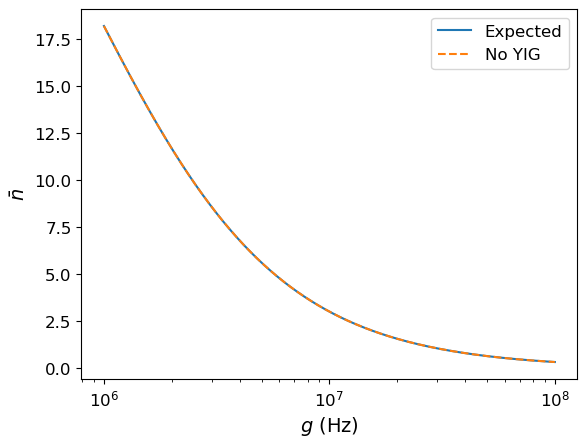

In [19]:
plt.semilogx(g, expected_nbar, label='Expected')
plt.semilogx(g, no_yig_nbar, '--', label='No YIG')
plt.xlabel("$g$ (Hz)")
plt.ylabel("$\\bar{n}$")
plt.legend()

In [20]:
# Now we want to compare the output spectra
r = 2 * np.pi * 229e3
γ = 2 * np.pi * 140e3
κ = 2 * np.pi * 185.1e3
g = 2 * np.pi * 197.7e3
P = 0.8
nc = 0.5 * (1 - P) / P
ω = 2 * np.pi * np.linspace(-1.5, 1.5, 1000) * 1e6 # Hz
Δ = 2 * np.pi * np.linspace(-4, 4, 1000) * 1e6 # Hz
ωm, Δm = np.meshgrid(ω, Δ)
expected_spectra_a = nv_output_spec(ωm, g, r, κ, γ, nT, nc, Δm - 2.15 * 2 * np.pi * 1e6)
expected_spectra_b = nv_output_spec(ωm, g, r, κ, γ, nT, nc, Δm - 0)
expected_spectra_c = nv_output_spec(ωm, g, r, κ, γ, nT, nc, Δm + 2.15 * 2 * np.pi * 1e6)
expected_spectra = 0.33 * expected_spectra_a + 0.33 * expected_spectra_b + 0.33 * expected_spectra_c

In [21]:
calculated_spectra_a = full_output_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm - 2.15 * 2 * np.pi * 1e6, 0)
calculated_spectra_b = full_output_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm - 0, 0)
calculated_spectra_c = full_output_spec(ωm, g, r, 0, 0, κ, γ, nT, nc, 0, Δm + 2.15 * 2 * np.pi * 1e6, 0)
calculated_spectra = 0.33 * calculated_spectra_a + 0.33 * calculated_spectra_b + 0.33 * calculated_spectra_c

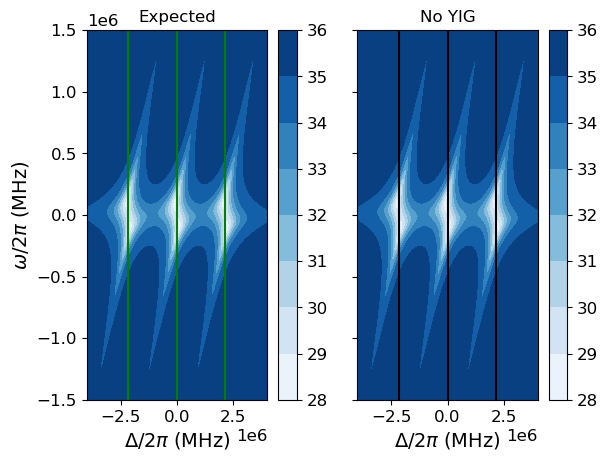

In [22]:
fig1 = plt.figure(1)
ax = fig1.subplots(1, 2, sharex='all', sharey='all')
im1 = ax[0].contourf(Δm / (2 * np.pi), ωm / (2 * np.pi), expected_spectra, cmap='Blues')
ax[0].axvline(x=-2.15 * 1e6, color='g')
ax[0].axvline(x=0, color='g')
ax[0].axvline(x=2.15 * 1e6, color='g')
ax[0].set_xlabel("$\\Delta / 2\\pi$ (MHz)")
ax[0].set_ylabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_title("Expected")

im2 = ax[1].contourf(Δm / (2 * np.pi), ωm / (2 * np.pi), calculated_spectra, cmap='Blues')
ax[1].axvline(x=-2.15 * 1e6, color='k')
ax[1].axvline(x=0, color='k')
ax[1].axvline(x=2.15 * 1e6, color='k')
ax[1].set_xlabel("$\\Delta / 2\\pi$ (MHz)")
ax[1].set_title("No YIG")
fig1.colorbar(im1)
fig1.colorbar(im2)

Text(0.5, 0, '$\\omega / 2\\pi$ (MHz)')

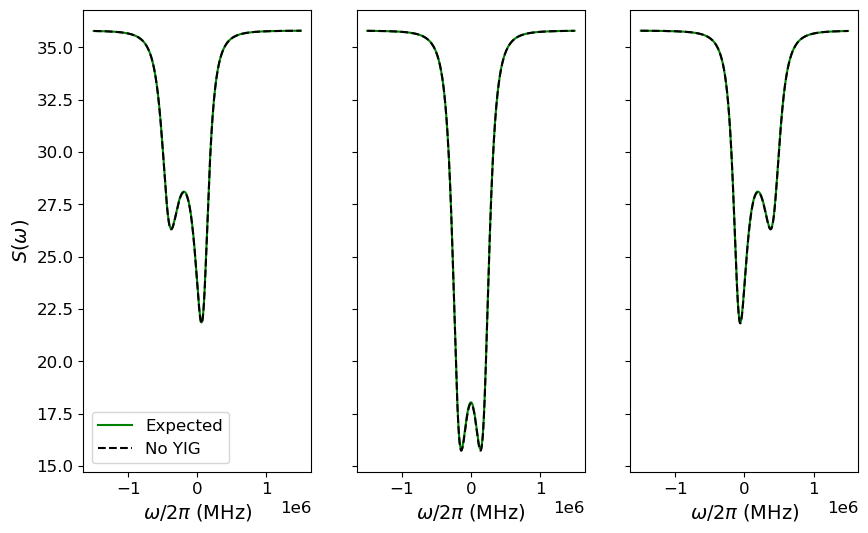

In [23]:
exp_l = nv_output_spec(ω, g, r, κ, γ, nT, nc, -2.15 * 1e6)
exp_m = nv_output_spec(ω, g, r, κ, γ, nT, nc, 0)
exp_r = nv_output_spec(ω, g, r, κ, γ, nT, nc, 2.15 * 1e6)

calc_l = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, - 2.15 * 1e6, 0)
calc_m = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, 0, 0)
calc_r = full_output_spec(ω, g, r, 0, 0, κ, γ, nT, nc, 0, 2.15 * 1e6, 0)

fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
ax[0].plot(ω / (2 * np.pi), exp_l, 'g-', label='Expected')
ax[0].plot(ω / (2 * np.pi), calc_l, 'k--', label='No YIG')
ax[0].set_xlabel("$\\omega / 2\\pi$ (MHz)")
ax[0].set_ylabel("$S(\\omega)$")
ax[0].legend()

ax[1].plot(ω / (2 * np.pi), exp_m, 'g-')
ax[1].plot(ω / (2 * np.pi), calc_m, 'k--')
ax[1].set_xlabel("$\\omega / 2\\pi$ (MHz)")

ax[2].plot(ω / (2 * np.pi), exp_r, 'g-')
ax[2].plot(ω / (2 * np.pi), calc_r, 'k--')
ax[2].set_xlabel("$\\omega / 2\\pi$ (MHz)")

### Cavity mode YIG Calculations

In [24]:
# Redefine parameters to avoid accidentally calculating things
ωc = 2 * np.pi * 2.87e9  # Hz
κ = 1
T = 5
Q = 2.5e4
γ = ωc / Q
P = 1
nc = 0.5 * (1 - P) / P
nT = photons_from_temp(ωc, T)

In [25]:
# First we'll do a sweep over g and gy
g = np.logspace(6, 8, 1000)
r = g.copy()
gy = np.logspace(6, 8, 1000)
χ = gy.copy()

ny_l = 0.1 * nT
ny_e = nT
ny_g = 10 * nT
print(nT, temp_from_photons(ωc, nT))

35.79937923012842 4.999999999999987


In [26]:
nbar_l = np.zeros((g.size, gy.size), dtype=complex)
nbar_e = np.zeros((g.size, gy.size), dtype=complex)
nbar_g = np.zeros((g.size, gy.size), dtype=complex)
for i, G, in enumerate(g):
    for j, Gy in enumerate(gy):
        temp_a_list = get_a_list(κ, γ, r[i], χ[j], G, Gy)
        temp_b_list = get_b_list(κ, γ, r[i], χ[j], G, Gy, nc, ny_l, nT)
        M_det = m_det(temp_b_list, temp_a_list)
        L_det = l_det(temp_a_list)
        nbar_l[i][j] = 1 / (2*np.abs(temp_a_list[0])) * np.abs(M_det / L_det)

        temp_a_list = get_a_list(κ, γ, r[i], χ[j], G, Gy)
        temp_b_list = get_b_list(κ, γ, r[i], χ[j], G, Gy, nc, ny_e, nT)
        M_det = m_det(temp_b_list, temp_a_list)
        L_det = l_det(temp_a_list)
        nbar_e[i][j] = 1 / (2*np.abs(temp_a_list[0])) * np.abs(M_det / L_det)

        temp_a_list = get_a_list(κ, γ, r[i], χ[j], G, Gy)
        temp_b_list = get_b_list(κ, γ, r[i], χ[j], G, Gy, nc, ny_g, nT)
        M_det = m_det(temp_b_list, temp_a_list)
        L_det = l_det(temp_a_list)
        nbar_g[i][j] = 1 / (2*np.abs(temp_a_list[0])) * np.abs(M_det / L_det)

/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/matplotlib/contour.py:1568: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = z.max().astype(float)
/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/matplotlib/contour.py:1569: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = z.min().astype(float)
/home/jacob/anaconda3/envs/mode_cooling/lib/python3.11/site-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


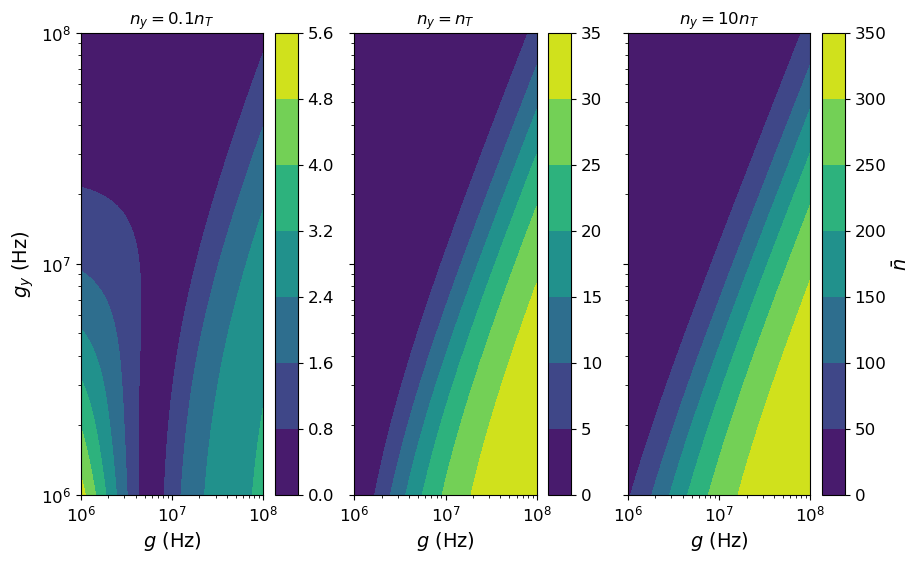

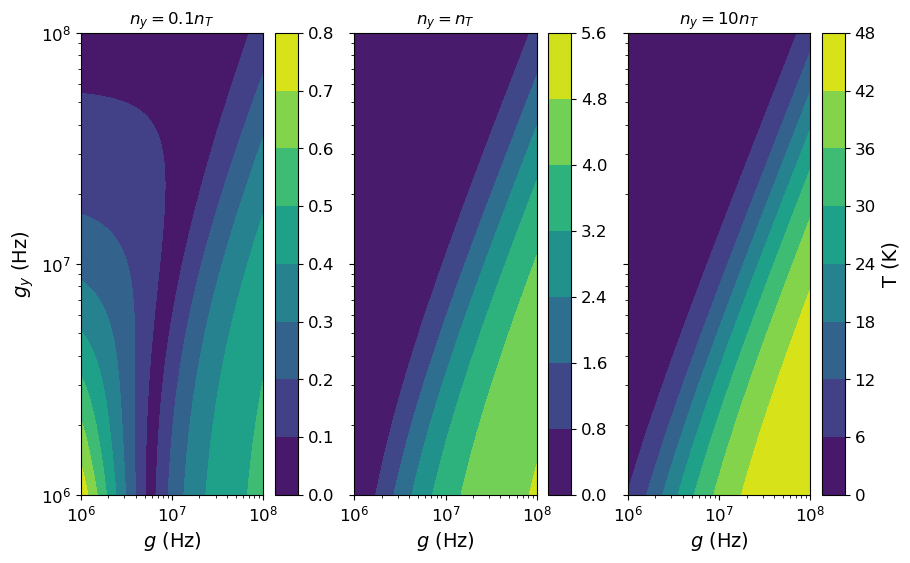

In [27]:
gm, gym = np.meshgrid(g, gy)
fig1 = plt.figure(1, figsize=(10, 6))
ax = fig1.subplots(1, 3, sharex='all', sharey='all')
im1 = ax[0].contourf(gm, gym, nbar_l)
ax[0].set_ylabel("$g_y$ (Hz)")
ax[0].set_xlabel("$g$ (Hz)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title("$n_y = 0.1n_T$")
fig1.colorbar(im1)

im2 = ax[1].contourf(gm, gym, nbar_e)
ax[1].set_xlabel("$g$ (Hz)")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title("$n_y = n_T$")
fig1.colorbar(im2)

im3 = ax[2].contourf(gm, gym, nbar_g)
ax[2].set_xlabel("$g$ (Hz)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title("$n_y = 10n_T$")
fig1.colorbar(im3, label='$\\bar{n}$')

fig2 = plt.figure(2, figsize=(10, 6))
ax2 = fig2.subplots(1, 3, sharex='all', sharey='all')
im21 = ax2[0].contourf(gm, gym, temp_from_photons(ωc, nbar_l))
ax2[0].set_ylabel("$g_y$ (Hz)")
ax2[0].set_xlabel("$g$ (Hz)")
ax2[0].set_xscale('log')
ax2[0].set_yscale('log')
ax2[0].set_title("$n_y = 0.1n_T$")
fig2.colorbar(im21)

im22 = ax2[1].contourf(gm, gym, temp_from_photons(ωc, nbar_e))
ax2[1].set_xlabel("$g$ (Hz)")
ax2[1].set_xscale('log')
ax2[1].set_yscale('log')
ax2[1].set_title("$n_y = n_T$")
fig2.colorbar(im22)

im23 = ax2[2].contourf(gm, gym, temp_from_photons(ωc, nbar_g))
ax2[2].set_xlabel("$g$ (Hz)")
ax2[2].set_xscale('log')
ax2[2].set_yscale('log')
ax2[2].set_title("$n_y = 10n_T$")
fig2.colorbar(im23, label='T (K)')

In [28]:
# Let's replicate the results with regard to physical parameters from the nv_expected_cooling file
# First redefine parameters
ωc = 2 * np.pi * 2.87e9  # Hz
κ = 1
T = 5
Q = 2.5e4
γ = ωc / Q
P = 1
nc = 0.5 * (1 - P) / P
nT = photons_from_temp(ωc, T)
gy = 1e7
χ = gy
ny = nT

In [29]:
# We'll normalize the diamond volume by the mode volume
V = 1.7  # cm^3
Vd = np.linspace(1e-2, 1.7, 1000)
ρ = np.logspace(-3, 3, 1000)  # ppm

In [30]:
# Let's use gs = 1 Hz for now
gs = 1

In [31]:
# Now create mesh grid for collective g values
ρm, Vdm = np.meshgrid(ρ, Vd)

# Then
N = ρm * 1e-6 * (3.53 * Vdm / 12.01) * 6.022e23
g1 = np.sqrt(N) * gs
r = g1.copy()

In [32]:
print("Min NVs: %3e, Max NVs: %3e" % (N.min(), N.max()))
print("Min g1: %3e, Max g1: %3e" % (g1.min(), g1.max()))

Min NVs: 1.769997e+12, Max NVs: 3.008994e+20
Min g1: 1.330412e+06, Max g1: 1.734645e+10


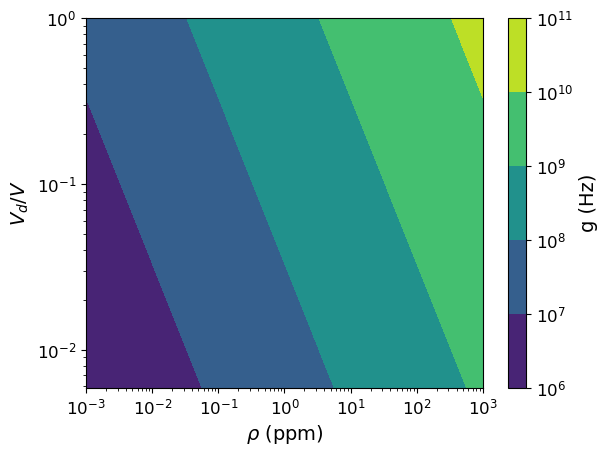

In [33]:
plt.contourf(ρm, Vdm / V, g1, norm=mpl.colors.LogNorm())
plt.xlabel("$\\rho$ (ppm)")
plt.ylabel("$V_d / V$")
plt.xscale('log')
plt.yscale('log')
plt.colorbar(label='g (Hz)')

In [34]:
no_yig_nbar = np.zeros((ρ.shape[0], Vd.shape[0]), dtype=complex)
for i in range(ρ.shape[0]):
    for j in range(Vd.shape[0]):
        temp_a0 = 1
        temp_a1 = 1j*(r[i][j] + κ + γ) / 2
        temp_a2 = -(κ + γ) * r[i][j] / 4 - g1[i][j] ** 2
        temp_b0 = (κ + γ) * nT
        temp_b1 = (κ + γ) * nT / 4 * r[i][j] ** 2 + r[i][j] * nc + g1[i][j] ** 2

        temp_M2 = np.array([[temp_b0, temp_b1], [temp_a0, temp_a2]])
        temp_M2_det = linalg.det(temp_M2)
        temp_L2 = np.array([[temp_a1, 0], [temp_a0, temp_a2]])
        temp_L2_det = linalg.det(temp_L2)

        no_yig_nbar[i][j] = 1 / (2 *np.abs(temp_a0)) * np.abs(temp_M2_det / temp_L2_det)

In [35]:
yig_nbar = np.zeros((ρ.shape[0], Vd.shape[0]), dtype=complex)
for i in range(ρ.shape[0]):
    for j in range(Vd.shape[0]):
        temp_a_list = get_a_list(κ, γ, r[i][j], χ, g1[i][j], gy)
        temp_b_list = get_b_list(κ, γ, r[i][j], χ, g1[i][j], gy, nc, ny, nT)
        M_det = m_det(temp_b_list, temp_a_list)
        L_det = l_det(temp_a_list)
        yig_nbar[i][j] = 1 / (2*np.abs(temp_a_list[0])) * np.abs(M_det / L_det)

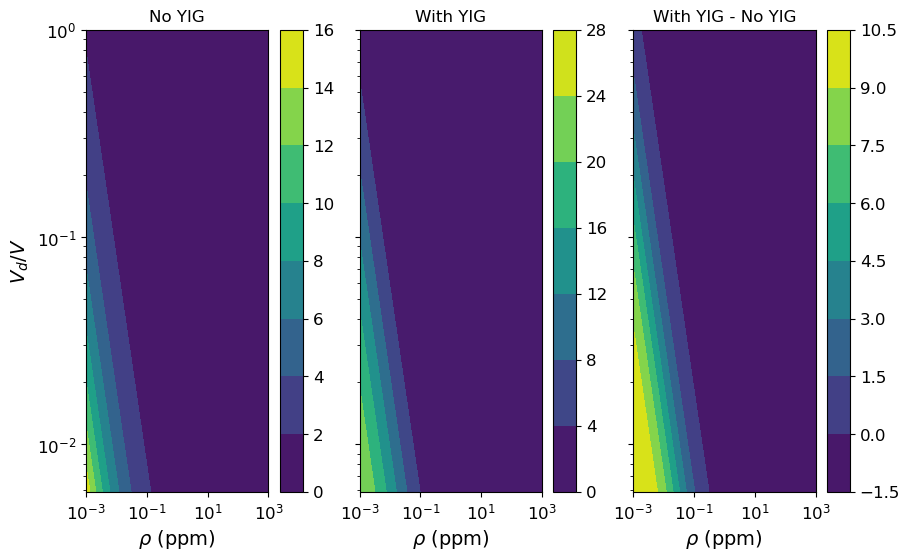

In [36]:
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
im0 = ax[0].contourf(ρm, Vdm / V, no_yig_nbar)
ax[0].set_xlabel("$\\rho$ (ppm)")
ax[0].set_ylabel("$V_d / V$")
ax[0].set_title("No YIG")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
fig.colorbar(im0)

im1 = ax[1].contourf(ρm, Vdm / V, yig_nbar)
ax[1].set_xlabel("$\\rho$ (ppm)")
ax[1].set_title("With YIG")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.colorbar(im1)

im2 = ax[2].contourf(ρm, Vdm / V, yig_nbar - no_yig_nbar)
ax[2].set_xlabel("$\\rho$ (ppm)")
ax[2].set_title("With YIG - No YIG")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
fig.colorbar(im2)

In [37]:
nyl = 0.5 * nT

In [38]:
yig_nbar_l = np.zeros((ρ.shape[0], Vd.shape[0]), dtype=complex)
for i in range(ρ.shape[0]):
    for j in range(Vd.shape[0]):
        temp_a_list = get_a_list(κ, γ, r[i][j], χ, g1[i][j], gy)
        temp_b_list = get_b_list(κ, γ, r[i][j], χ, g1[i][j], gy, nc, nyl, nT)
        M_det = m_det(temp_b_list, temp_a_list)
        L_det = l_det(temp_a_list)
        yig_nbar_l[i][j] = 1 / (2*np.abs(temp_a_list[0])) * np.abs(M_det / L_det)

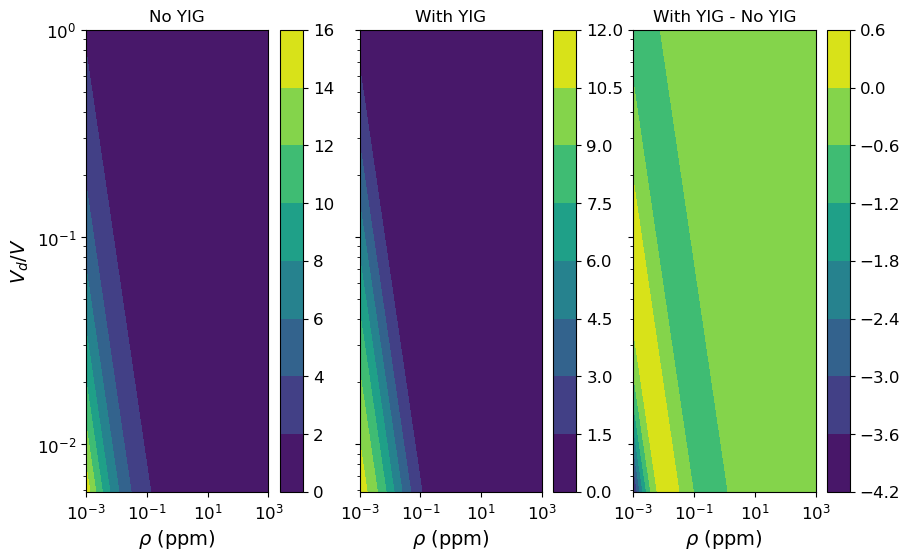

In [39]:
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
im0 = ax[0].contourf(ρm, Vdm / V, no_yig_nbar)
ax[0].set_xlabel("$\\rho$ (ppm)")
ax[0].set_ylabel("$V_d / V$")
ax[0].set_title("No YIG")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
fig.colorbar(im0)

im1 = ax[1].contourf(ρm, Vdm / V, yig_nbar_l)
ax[1].set_xlabel("$\\rho$ (ppm)")
ax[1].set_title("With YIG")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.colorbar(im1)

im2 = ax[2].contourf(ρm, Vdm / V, yig_nbar_l - no_yig_nbar)
ax[2].set_xlabel("$\\rho$ (ppm)")
ax[2].set_title("With YIG - No YIG")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
fig.colorbar(im2)

In [40]:
nyg = 1.5 * nT

In [41]:
yig_nbar_g = np.zeros((ρ.shape[0], Vd.shape[0]), dtype=complex)
for i in range(ρ.shape[0]):
    for j in range(Vd.shape[0]):
        temp_a_list = get_a_list(κ, γ, r[i][j], χ, g1[i][j], gy)
        temp_b_list = get_b_list(κ, γ, r[i][j], χ, g1[i][j], gy, nc, nyg, nT)
        M_det = m_det(temp_b_list, temp_a_list)
        L_det = l_det(temp_a_list)
        yig_nbar_g[i][j] = 1 / (2*np.abs(temp_a_list[0])) * np.abs(M_det / L_det)

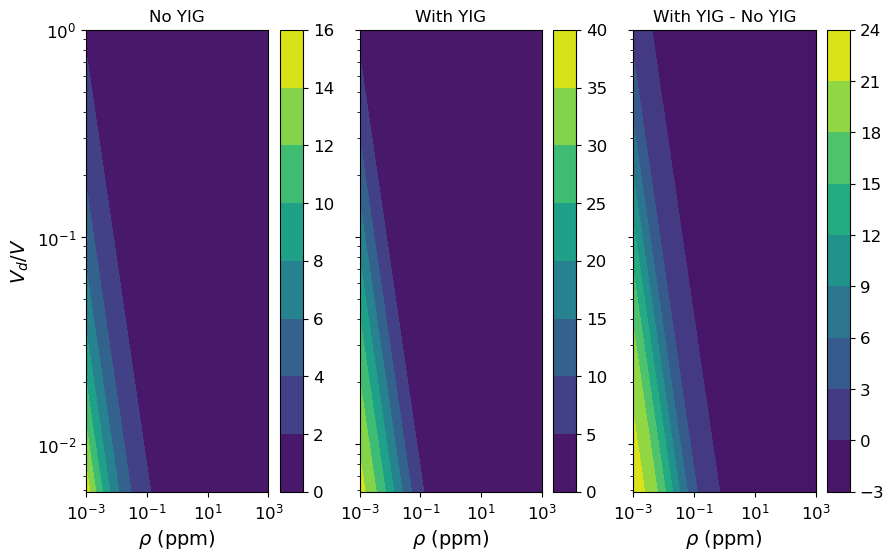

In [42]:
fig = plt.figure(1, figsize=(10, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
im0 = ax[0].contourf(ρm, Vdm / V, no_yig_nbar)
ax[0].set_xlabel("$\\rho$ (ppm)")
ax[0].set_ylabel("$V_d / V$")
ax[0].set_title("No YIG")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
fig.colorbar(im0)

im1 = ax[1].contourf(ρm, Vdm / V, yig_nbar_g)
ax[1].set_xlabel("$\\rho$ (ppm)")
ax[1].set_title("With YIG")
ax[1].set_xscale('log')
ax[1].set_yscale('log')
fig.colorbar(im1)

im2 = ax[2].contourf(ρm, Vdm / V, yig_nbar_g - no_yig_nbar)
ax[2].set_xlabel("$\\rho$ (ppm)")
ax[2].set_title("With YIG - No YIG")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
fig.colorbar(im2)

### Output spectrum YIG Calculations

We'll plot the spectrum as a function of $\omega$ and $\Delta$ for fixed values of $\Omega$.  Then we'll try fixed values of $\Delta$.  First we need to determine the region(s) of interest.

In [43]:
# First define parameters
ωc = 2 * np.pi * 2.87e9
g = 1e7
r = g
gy = 1e8
χ = gy
T = 5
Q = 2.5e4
γ = ωc / Q
κ = 1
P = 1
nc = 0.5 * (1 - P) / P
nT = photons_from_temp(ωc, T)
ny = nT
Ωa = 1e6
Ωb = 1e9
Ωc = 1e12

ω = 2 * np.pi * np.logspace(0, 9, 1000)
Δ = 2 * np.pi * np.logspace(0, 9, 1000)

ωm, Δm = np.meshgrid(ω, Δ)

In [44]:
speca = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δm, Ωa)
specb = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δm, Ωb)
specc = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δm, Ωc)

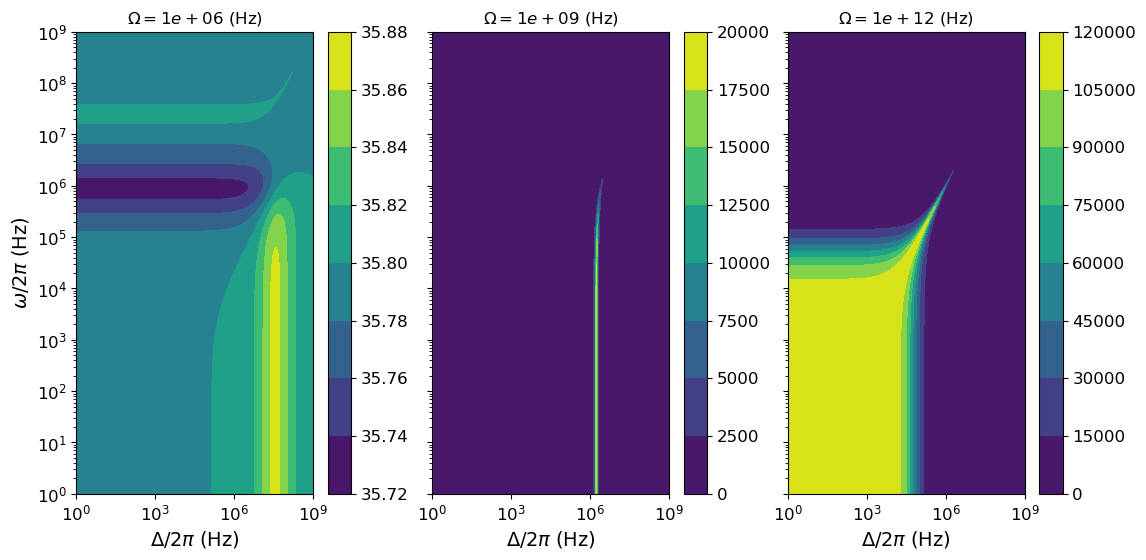

In [45]:
fig = plt.figure(1, figsize=(13, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
ima = ax[0].contourf(Δm / (2 * np.pi), ωm / (2 * np.pi), speca)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title("$\\Omega = {%.e} $ (Hz)" % Ωa)
ax[0].set_xlabel("$\\Delta / 2\\pi$ (Hz)")
ax[0].set_ylabel("$\\omega / 2\\pi$ (Hz)")
fig.colorbar(ima)

imb = ax[1].contourf(Δm / (2 * np.pi), ωm / (2 * np.pi), specb)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title("$\\Omega = {%.e} $ (Hz)" % Ωb)
ax[1].set_xlabel("$\\Delta / 2\\pi$ (Hz)")
fig.colorbar(imb)

imc = ax[2].contourf(Δm / (2 * np.pi), ωm / (2 * np.pi), specc)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title("$\\Omega = {%.e} $ (Hz)" % Ωc)
ax[2].set_xlabel("$\\Delta / 2\\pi$ (Hz)")
fig.colorbar(imc)

In [46]:
ω = 2 * np.pi * np.linspace(-2, 2, 1000) * 1e6
Δ = 2 * np.pi * np.linspace(-4, 4, 1000) * 1e6
ωm, Δm = np.meshgrid(ω, Δ)

Text(0.5, 0, '$\\Delta / 2 \\pi$ (Hz)')

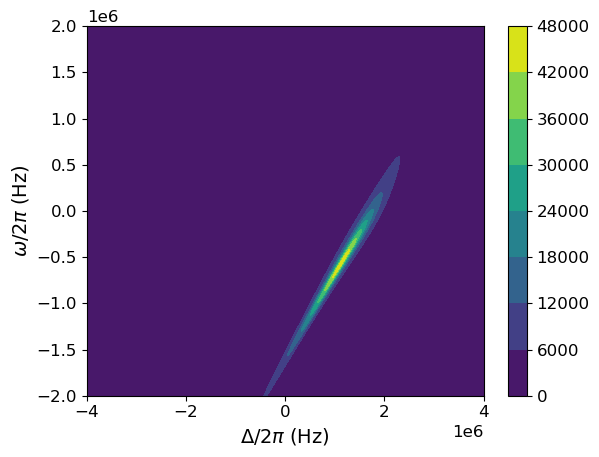

In [47]:
Ω = 1e9
spec = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δm, Ω)
plt.contourf(Δm / (2 * np.pi), ωm / (2 * np.pi), spec)
plt.colorbar()
plt.ylabel("$\\omega / 2 \\pi$ (Hz)")
plt.xlabel("$\\Delta / 2 \\pi$ (Hz)")

In [48]:
Δa, Δb, Δc = 1e3, 1e6, 1e9

ω = 2 * np.pi * np.logspace(0, 14, 1000)
Ω = 2 * np.pi * np.logspace(0, 14, 1000)

ωm, Ωm = np.meshgrid(ω, Ω)

In [49]:
speca = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δa, Ωm)
specb = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δb, Ωm)
specc = full_output_spec(ωm, g, r, gy, χ, κ, γ, nT, nc, ny, Δc, Ωm)

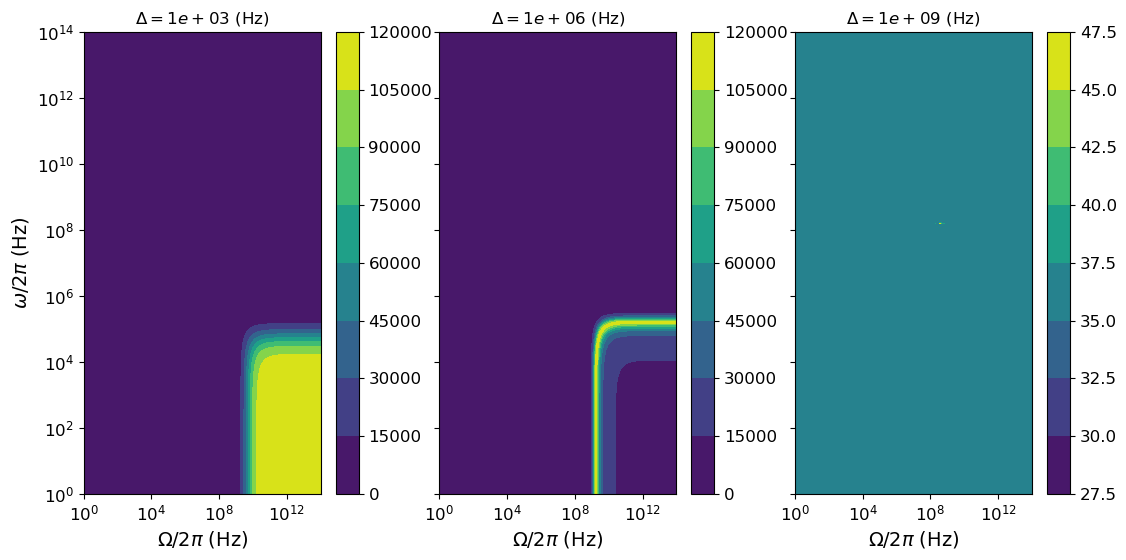

In [50]:
fig = plt.figure(1, figsize=(13, 6))
ax = fig.subplots(1, 3, sharex='all', sharey='all')
ima = ax[0].contourf(Ωm / (2 * np.pi), ωm / (2 * np.pi), speca)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title("$\\Delta = {%.e} $ (Hz)" % Δa)
ax[0].set_xlabel("$\\Omega / 2\\pi$ (Hz)")
ax[0].set_ylabel("$\\omega / 2\\pi$ (Hz)")
fig.colorbar(ima)

imb = ax[1].contourf(Ωm / (2 * np.pi), ωm / (2 * np.pi), specb)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title("$\\Delta = {%.e} $ (Hz)" % Δb)
ax[1].set_xlabel("$\\Omega / 2\\pi$ (Hz)")
fig.colorbar(imb)

imc = ax[2].contourf(Ωm / (2 * np.pi), ωm / (2 * np.pi), specc)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title("$\\Delta = {%.e} $ (Hz)" % Δc)
ax[2].set_xlabel("$\\Omega / 2\\pi$ (Hz)")
fig.colorbar(imc)